In [1]:
import os
import sys
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns

# Allow imports from project dir
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.Wordle import Wordle

In [3]:
def calc_lfl(word_list, bow, colname):
    """    
    Calculate Likelihood of word from Letter Frequency given in a bag of words 5x26 matrix 
        see BJA-01.2-make-word-lists
    """
    result = []
    for word in word_list:
        likelihood = 1
        for i, letter in enumerate(word):
            likelihood *= bow[str(i)][letter]
        result.append((word, likelihood))
    return pd.DataFrame(sorted(result, key=lambda x: x[1], reverse=True), columns=['w', colname]).set_index('w') 
    
    



def total_green_letter_prob(word, bow):
    # Finds total probability that you will get at least 1 green in any position by testing this word
    prob = 0
    for i, letter in enumerate(word):
        prob += bow[str(i)][letter]
    return prob

def prob_of_2_greens(word):
    # How do you calculate this? 
    pass

def total_yellow_letter_prob(word):
    prob = 0 
    
    
# Allow for repeat letters with max_repeats
def contains_repeats(word, search, max_repeats):
    s = set(letter for letter in search)
    repeats = 0
    for letter in word:
        if letter in s:
            repeats += 1
    if repeats <= max_repeats:
        return False
    else:
        return True

In [4]:
# word list with frequencies
wl = pd.read_csv(r'..\data\processed\wordle_google_freq_word_list.csv', index_col=0)
alphabet = 'abcdefghijklmnopqrstuvwxyz'
# Read in  Bags of Letters matrices (AKA bag-of-words = bow) 
with open(r'..\data\processed\bags_of_words.json', 'r') as infile:
    all_bow = json.load(infile, parse_int=False)
bow17 = all_bow['combined_wordle_google']
bowwordle = all_bow['all_wordle']
bowcur = all_bow['wordle_curated']

bow17lfl = calc_lfl(wl.index, bow17, colname='all')
bowwordlelfl = calc_lfl(wl.loc[wl['in_wordle']].index, bowwordle, colname='wordle')
bowcurlfl = calc_lfl(wl.loc[wl['in_wordle_curated']].index, bowcur, colname='curated')

lfl = pd.concat([bow17lfl, bowwordlelfl, bowcurlfl], axis=1, sort=True)
# lfl.to_csv(r'..\data\processed\letter_freq_likelihoods.csv')

## Question:

## What sequence of words provides the highest chance of finding greens and yellows, while also not repeating any letters (i.e. maximizing grays)? 

### Make a function that iterates through the top 200 words with highest letter-frequency probability and finds the sequence of 5 words that has no repeats 
### If it can't find a next word with no repeat, then take the word with just one repeat (i.e. len(set(word)) == 4) 
### Then sum the calculated letter-freq probabilities of all the words 

### This will give a probability of finding a green but it doesn't include the helpful contribution from simply covering more letters and finding more grays. 
### To account for grays, include a "if you have X gray letter, what % of words are excluded?"

## Important! The dataset for this optimization must use the entire wordle list, but with their letter-freq probabilities calculated from the curated list. 

## Then use the top 200 from curated as starting points for the calculation.

In [9]:
data = wl.loc[wl['in_wordle'], ['in_wordle_curated']]
data['wlh'] = calc_lfl(data.index, bowcur, colname='wlh')   # wlh = Word Likelihood from letter frequency

# tglp = Total Green Letter Probability
# sum of all probabilities of finding that letter in that position 
data['tglp'] = data.index.map(lambda x: total_green_letter_prob(x, bow=bowcur)) 
curated_sorted = data.sort_values(['in_wordle_curated', 'tglp'], ascending=False)
curated_words = curated_sorted.loc[curated_sorted['in_wordle_curated']].index
display(curated_words)
data = data.sort_values('tglp', ascending=False)
data['unique_letters'] = data.index.map(lambda x: len(set(x)))
data.head(10)

Index(['slate', 'sauce', 'slice', 'shale', 'saute', 'share', 'sooty', 'shine',
       'suite', 'crane',
       ...
       'lymph', 'jumbo', 'igloo', 'ethic', 'unzip', 'umbra', 'affix', 'ethos',
       'inbox', 'nymph'],
      dtype='object', name='w', length=2315)

,in_wordle_curated,wlh,tglp,unique_letters
w,,,,
saree,False,0.000037,0.680346,4
sooey,False,0.000043,0.678618,4
soree,False,0.000034,0.669546,4
saine,False,0.000034,0.666091,5
soare,False,0.000030,0.660043,5
saice,False,0.000029,0.653132,5
sease,False,0.000030,0.652268,3
seare,False,0.000026,0.644060,4
seine,False,0.000027,0.639309,4


In [62]:
def contains_repeats(word, search, max_repeats):
    # Allow for repeat letters with max_repeats
    s = set(letter for letter in search)
    repeats = 0
    for letter in word:
        if letter in s:
            repeats += 1
    if repeats <= max_repeats:
        return False
    else:
        return True

def calc_summed_tglp_and_repeats(sequence):
    repeats = set()
    pos_dict = {0: [], 1: [], 2: [], 3: [], 4: []}
    tglp = 0
    for word in sequence:
        for i, letter in enumerate(word):
            repeats.add(letter)
            if letter not in pos_dict[i]:
                tglp += bowcur[str(i)][letter]
            pos_dict[i].append(letter)
    return tglp, len(repeats)

def check_word(word, pos_dict, combined_words, max_num_repeats_prev_guesses, max_num_repeats_next_guess):
    """
    Optimize the guess sequence search algorithm with following conditions:
    1. Do not repeat letters previously guessed (maximize letter information based on grays/yellows/greens)
    2. Next guess should maximize number of new letters, up to max_num_repeats_next_guess
    3. If you must guess with repeat letters, do not repeat letters in the same position as before
    
    Perform these tests with word list ranked by TGLP, and again ranked by word likelihood. 
    
    Return True if the word being tested meets all 3 conditions
    
    word: string
    pos_dict: dict of index: list of letters used in this position
    combined_words: string of combined words in sequence
    max_num_repeat_prev_guesses: int of maximum number of repeat letters allowed from previous guesses
    max_num_repeats_next_guess: int of maximum number of repeat letters allowed in next guess
    """
    
    # Check for condition #3
    for i, letter in enumerate(word):
        if letter in pos_dict[i]:
            return False
    
    # Check condition #2, that the word doesn't repeat too many letters
    if not len(set(word)) >= (5 - max_num_repeats_next_guess):
        return False
    
    # Check for condition #1: do not repeat letters previously guessed
        # if contains_repeats returns True, then it contains repeats which is bad, so return False
        # if contains_repeats returns False, then within tolerance, the word is good
        # Therefore return the opposite of contains_repeats()
    return not contains_repeats(word, combined_words, max_repeats=max_num_repeats_prev_guesses)   

def add_to_pos_dict(word, pos_dict):
    for i, letter in enumerate(word):
        pos_dict[i].append(letter)
    return pos_dict

In [63]:
# Test cases
test_sequence = ['saint', 'cored', 'bulky', 'whomp']
print(calc_summed_tglp_and_repeats(test_sequence))

print(contains_repeats('saint', 'qdghy', 0)) # does not contain any repeats, so False
print(contains_repeats('saint', 'adghy', 0)) # does contain a repeat (letter 'a') so return True
print(contains_repeats('saint', 'adghy', 1)) # contains 1 repeat, which is within tolerance, so return False

(1.698488120950324, 19)
False
True
False


In [158]:
tglp_words = data.sort_values('tglp', ascending=False).index
tglp_list = data['tglp'].to_list()

# start_words_list = data.loc[data['in_wordle_curated']].index
# results = []

# List of tuples of (number of repeats from previous guesses, number of repeats in next guess)
# Increment each one, corresponding with a looser search tolerance
priority_list = [(0, 0), (1, 0), (1, 1), (2, 1), (3, 1), (4, 1), (3, 2)]

def guess_sequence_search(word_list, word_value, results, priority_list):
    """
    word_list: list of words in ranked order biggest to smallest, same as word_value
    word_value: list of word's values
    results: list to append to
    priority_list: priority ranking for check_word() function 
    """
    for start_word in word_list[0:1000]:
        combined_words = start_word
    #     summed_tglp = data.loc[start_word, 'tglp']
        sequence = [start_word]
        pos_dict = {0: [], 1: [], 2: [], 3: [], 4: []}
        pos_dict = add_to_pos_dict(start_word, pos_dict)

        # Iterate until the sequence is filled with 4 words beyond start_word, or priority_list runs out
        for _ in range(4):
            # Non-recursive implementation
            for test_word, tglp in zip(words, word_value): 
                if check_word(test_word, pos_dict, combined_words, priority_list[0][0], priority_list[0][1]):
                    sequence.append(test_word)
                    pos_dict = add_to_pos_dict(test_word, pos_dict)
                    combined_words += test_word
                    break
                if test_word == words[-1]:
                    for test_word, tglp in zip(words, word_value):
                        if check_word(test_word, pos_dict, combined_words, priority_list[1][0], priority_list[1][1]):
                            sequence.append(test_word)
                            pos_dict = add_to_pos_dict(test_word, pos_dict)
                            combined_words += test_word
                            break
                        if test_word == words[-1]:
                            for test_word, tglp in zip(words, word_value):
                                if check_word(test_word, pos_dict, combined_words, priority_list[2][0], priority_list[2][1]):
                                    sequence.append(test_word)
                                    pos_dict = add_to_pos_dict(test_word, pos_dict)
                                    combined_words += test_word
                                    break
                                if test_word == words[-1]:
                                    for test_word, tglp in zip(words, word_value):
                                        if check_word(test_word, pos_dict, combined_words, priority_list[3][0], priority_list[3][1]):
                                            sequence.append(test_word)
                                            pos_dict = add_to_pos_dict(test_word, pos_dict)
                                            combined_words += test_word
                                            break
                                        if test_word == words[-1]:
                                            for test_word, tglp in zip(words, word_value):
                                                if check_word(test_word, pos_dict, combined_words, priority_list[4][0], priority_list[4][1]):
                                                    sequence.append(test_word)
                                                    pos_dict = add_to_pos_dict(test_word, pos_dict)
                                                    combined_words += test_word
                                                    break
                                                if test_word == words[-1]:
                                                    for test_word, tglp in zip(words, word_value):
                                                        if check_word(test_word, pos_dict, combined_words, priority_list[5][0], priority_list[5][1]):
                                                            sequence.append(test_word)
                                                            pos_dict = add_to_pos_dict(test_word, pos_dict)
                                                            combined_words += test_word
                                                            break     
                                                        if test_word == words[-1]:
                                                            for test_word, tglp in zip(words, word_value):
                                                                if check_word(test_word, pos_dict, combined_words, priority_list[6][0], priority_list[6][1]):
                                                                    sequence.append(test_word)
                                                                    pos_dict = add_to_pos_dict(test_word, pos_dict)
                                                                    combined_words += test_word
                                                                    break   
        results.append(sequence)
        print(sequence)
    return results

['saree', 'bliny', 'chout', 'gramp', 'fjeld']
['sooey', 'brant', 'child', 'flump', 'gawks']
['soree', 'gaily', 'bundt', 'whack', 'frump']
['saine', 'borty', 'pluck', 'hewgh', 'fumed']
['soare', 'bliny', 'dutch', 'frump', 'gawks']
['saice', 'drony', 'flump', 'bight', 'wokka']
['sease', 'crony', 'built', 'whump', 'faded']
['seare', 'bliny', 'chout', 'faded', 'gopak']
['seine', 'coaly', 'brugh', 'tapet', 'fjord']
['slane', 'pricy', 'fouth', 'baked', 'gemma']
['soole', 'briny', 'chapt', 'fumed', 'gawks']
['siree', 'coaly', 'bundt', 'whomp', 'griff']
['seise', 'coaly', 'brunt', 'whomp', 'faded']
['cooee', 'slaty', 'brink', 'whump', 'gadid']
['soote', 'briny', 'cauld', 'khaph', 'gemma']
['slate', 'crony', 'guimp', 'vozhd', 'wauff']
['soily', 'crane', 'bumph', 'fated', 'wigga']
['soave', 'briny', 'mulct', 'hewgh', 'faded']
['samey', 'point', 'brugh', 'flack', 'dewax']
['sauce', 'briny', 'plotz', 'hewgh', 'domed']
['semee', 'coaly', 'print', 'faugh', 'widow']
['slice', 'praty', 'bound', 'hewgh

['sowne', 'clary', 'bight', 'fumed', 'qapik']
['sonde', 'clary', 'whipt', 'begum', 'viffs']
['blase', 'crony', 'whipt', 'fumed', 'skegg']
['snary', 'boite', 'pluck', 'hewgh', 'faded']
['caese', 'briny', 'poult', 'hewgh', 'fumed']
['sleer', 'coady', 'quint', 'whomp', 'gaffe']
['hooey', 'saint', 'pluck', 'fremd', 'bewig']
['stoae', 'briny', 'pluck', 'vozhd', 'maxim']
['frate', 'soily', 'chunk', 'paged', 'bemix']
['snore', 'gaily', 'butch', 'domed', 'pluff']
['boney', 'slart', 'quich', 'fadge', 'whomp']
['stole', 'briny', 'gauch', 'domed', 'quaff']
['maise', 'crony', 'gulph', 'skatt', 'boded']
['cline', 'soapy', 'brugh', 'fated', 'muzak']
['donee', 'slaty', 'brick', 'whump', 'gaffs']
['sadly', 'crine', 'fouth', 'begem', 'pukka']
['coley', 'saint', 'brugh', 'flamm', 'dewax']
['serge', 'coaly', 'quint', 'whomp', 'faded']
['raise', 'pouty', 'clank', 'hewgh', 'bided']
['saunt', 'corey', 'whilk', 'budge', 'flamm']
['prise', 'coaly', 'bundt', 'hewgh', 'skoff']
['arise', 'pouty', 'clank', 'hewgh

['suede', 'coaly', 'print', 'hewgh', 'kamik']
['conne', 'slaty', 'brugh', 'piked', 'maxim']
['bluey', 'saint', 'frock', 'vozhd', 'gimme']
['rainy', 'souce', 'delft', 'bumph', 'wigga']
['borne', 'slaty', 'quich', 'faded', 'grump']
['wrate', 'soily', 'chunk', 'faded', 'bebop']
['flare', 'shiny', 'compt', 'juked', 'bewig']
['stave', 'crony', 'build', 'whump', 'gaffs']
['baaed', 'soily', 'prunt', 'chowk', 'gimme']
['drice', 'slaty', 'bough', 'known', 'maxim']
['doole', 'saint', 'curvy', 'whump', 'graff']
['brosy', 'faine', 'mulct', 'vozhd', 'skegg']
['praty', 'slice', 'bound', 'hewgh', 'kamik']
['ragee', 'soily', 'bundt', 'whack', 'frump']
['coure', 'slaty', 'brink', 'whomp', 'faded']
['seedy', 'brant', 'choil', 'guimp', 'wauff']
['swage', 'crony', 'built', 'vozhd', 'kamik']
['payee', 'suint', 'broch', 'dwalm', 'foggy']
['goary', 'slice', 'bundt', 'whomp', 'jeffs']
['sheer', 'coaly', 'quint', 'badge', 'frump']
['brave', 'soily', 'chunk', 'dempt', 'gaffs']
['sated', 'crony', 'whilk', 'flump

['fluey', 'saint', 'broch', 'podge', 'muzak']
['sucre', 'gaily', 'month', 'bided', 'pluff']
['frape', 'soily', 'bundt', 'chowk', 'maxim']
['leany', 'souct', 'dhikr', 'gamme', 'vibex']
['posey', 'brant', 'child', 'muzak', 'gaffe']
['grisy', 'coate', 'blunk', 'whomp', 'faded']
['urare', 'soily', 'batch', 'pwned', 'muzak']
['sissy', 'crane', 'boult', 'whomp', 'faded']
['stipe', 'coaly', 'grund', 'bimah', 'waffs']
['silty', 'crane', 'bough', 'faded', 'kempt']
['sedge', 'coaly', 'print', 'bumph', 'wauff']
['boast', 'crine', 'plumy', 'hewgh', 'faded']
['brant', 'soily', 'pudge', 'chowk', 'maxim']
['mealy', 'suint', 'broch', 'fadge', 'kopek']
['doily', 'sauce', 'brant', 'whomp', 'vuggs']
['grade', 'soily', 'chunk', 'tempt', 'vibex']
['beige', 'slaty', 'cronk', 'whump', 'faded']
['prese', 'coaly', 'quint', 'hewgh', 'faded']
['chose', 'briny', 'fault', 'domed', 'spazz']
['carry', 'shine', 'boult', 'piped', 'flamm']
['grame', 'soily', 'bundt', 'chowk', 'pluff']
['shirt', 'coaly', 'bunde', 'frump

['scrae', 'bliny', 'fouth', 'paged', 'mujik']
['barry', 'slice', 'fount', 'whomp', 'gived']
['surgy', 'coate', 'blind', 'whomp', 'jeffs']
['morne', 'slaty', 'quich', 'faded', 'bebop']
['start', 'coney', 'build', 'whomp', 'gaffe']
['hairy', 'souce', 'plant', 'bided', 'muzak']
['beady', 'suint', 'frock', 'whelp', 'gamme']
['saved', 'crony', 'built', 'whump', 'goffs']
['smaze', 'crony', 'built', 'hewgh', 'faded']
['drave', 'soily', 'chunk', 'tempt', 'baffs']
['noose', 'clary', 'whipt', 'fumed', 'skegg']
['taint', 'souce', 'glyph', 'fremd', 'bevvy']
['foamy', 'slice', 'brunt', 'hewgh', 'paved']
['mamey', 'suint', 'broch', 'fjeld', 'pogge']
['torte', 'saucy', 'blind', 'whomp', 'graff']
['grese', 'coaly', 'quint', 'whomp', 'faded']
['goory', 'saine', 'mulct', 'khaph', 'bided']
['bribe', 'slaty', 'pound', 'chowk', 'maxim']
['beamy', 'suint', 'frock', 'whelp', 'gadge']
['maaed', 'soily', 'brunt', 'chowk', 'gippo']
['sains', 'corey', 'flump', 'bight', 'dewax']
['darre', 'soily', 'chunk', 'tempt

['flier', 'soapy', 'bundt', 'chowk', 'gamme']
['poesy', 'brant', 'child', 'muzak', 'gaffe']
['booed', 'slaty', 'prink', 'gauch', 'meffs']
['sawed', 'crony', 'built', 'khaph', 'gimme']
['tarry', 'slice', 'bound', 'whomp', 'graff']
['those', 'briny', 'cauld', 'swamp', 'goffs']
['wooly', 'saine', 'cruft', 'bumph', 'gived']
['proke', 'slaty', 'cuing', 'vozhd', 'bemix']
['solar', 'chine', 'bufty', 'paged', 'mekka']
['safed', 'crony', 'built', 'whump', 'glaze']
['oracy', 'shine', 'flump', 'beget', 'wadds']
['rooty', 'saine', 'pluck', 'hewgh', 'bided']
['drere', 'soily', 'chant', 'flump', 'bewig']
['surat', 'coney', 'whilk', 'badge', 'flamm']
['sithe', 'coaly', 'grund', 'blimp', 'waffs']
['douce', 'slaty', 'brink', 'whomp', 'gaffs']
['porny', 'saice', 'thumb', 'fjeld', 'wigga']
['shies', 'coaly', 'brunt', 'fadge', 'muzak']
['terce', 'soily', 'maund', 'khaph', 'vibex']
['clast', 'brine', 'podgy', 'muzak', 'fifth']
['lacey', 'suint', 'brogh', 'kopje', 'flamm']
['copse', 'briny', 'fault', 'hewgh

In [160]:
df = []
for sequence in results:
    df.append((*sequence, 
               *calc_summed_tglp_and_repeats(sequence),
               *calc_summed_tglp_and_repeats(sequence[:-1]),
               *calc_summed_tglp_and_repeats(sequence[:-2]), 
               *calc_summed_tglp_and_repeats(sequence[:-3])))
    

columns = ['w1', 'w2', 'w3', 'w4', 'w5', 
           'tglp5', 'nu5', 
           'tglp4', 'nu4',
           'tglp3', 'nu3',
           'tglp2', 'nu2']
df = pd.DataFrame(df, columns=columns)
for num in ['2', '3', '4', '5']:
    df['mean_tglp'+num] = df['tglp'+num]/int(num)
# tglp# = total green letter probability with that many words in the sequence
# nu# = Number of Unique letters in that sequence 
# mean_tglp# = average Total green letter probability gained per letter (not unique letter!!)
df

,w1,w2,w3,w4,w5,tglp5,nu5,tglp4,nu4,tglp3,nu3,tglp2,nu2,mean_tglp2,mean_tglp3,mean_tglp4,mean_tglp5
0,saree,bliny,chout,gramp,fjeld,2.198704,20,1.941685,17,1.590497,14,1.192657,9,0.596328,0.530166,0.485421,0.439741
1,sooey,brant,child,flump,gawks,2.074730,21,1.843197,18,1.572786,14,1.189201,9,0.594600,0.524262,0.460799,0.414946
2,soree,gaily,bundt,whack,frump,2.190929,21,1.892009,18,1.546868,14,1.192657,9,0.596328,0.515623,0.473002,0.438186
3,saine,borty,pluck,hewgh,fumed,2.075162,21,1.721382,18,1.482937,15,1.149028,10,0.574514,0.494312,0.430346,0.415032
4,soare,bliny,dutch,frump,gawks,2.004752,21,1.773218,18,1.474298,15,1.172354,10,0.586177,0.491433,0.443305,0.400950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,thole,saury,boink,cided,gramp,2.250972,19,1.899784,16,1.506263,14,1.068683,10,0.534341,0.502088,0.474946,0.450194
996,perce,soily,gaunt,bided,chawk,2.268683,19,1.928726,16,1.546004,14,1.105832,9,0.552916,0.515335,0.482181,0.453737
997,chape,soily,brunt,faded,muzak,2.216415,20,1.965875,17,1.555076,15,1.105832,10,0.552916,0.518359,0.491469,0.443283
998,slyly,crane,quoit,whump,boded,2.092009,19,1.676026,17,1.453132,13,1.079914,8,0.539957,0.484377,0.419006,0.418402


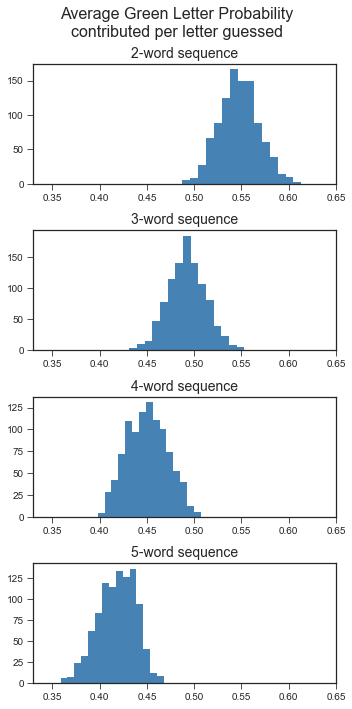

In [166]:
fig, ax = plt.subplots(nrows=4)
for i, num in enumerate(['2', '3', '4', '5']):
    ax[i].hist(df['mean_tglp'+num], bins=15, color='steelblue')
    ax[i].set_title(f'{num}-word sequence', fontsize=14)
    ax[i].set_xlim((0.33, 0.65))
fig.set_size_inches((5, 10))
fig.suptitle('Average Green Letter Probability\ncontributed per letter guessed', fontsize=16)

fig.tight_layout()


<AxesSubplot:>

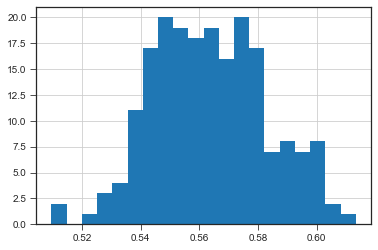

In [142]:
df['mean_tglp2'].hist(bins=20)

<AxesSubplot:>

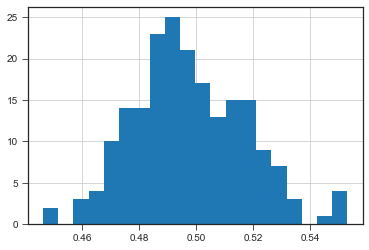

In [143]:
df['mean_tglp3'].hist(bins=20)

<AxesSubplot:>

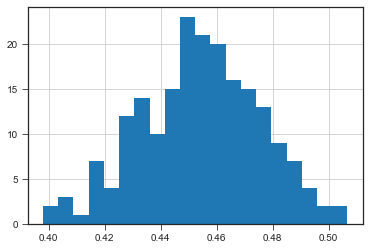

In [144]:
df['mean_tglp4'].hist(bins=20)

<AxesSubplot:>

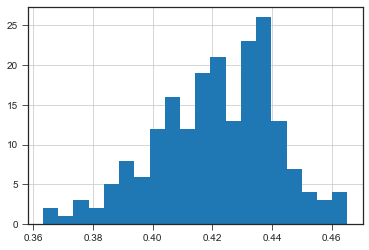

In [145]:
df['mean_tglp5'].hist(bins=20)